<a id='top'></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Predicting Nightly Mood Scores from Previously Submitted Mood, Sleep, and IEQ
Seeing if we can improve our predictive ability by including _even more_ data. 

Some good information can be found [here](https://towardsdatascience.com/comprehensive-guide-to-multiclass-classification-with-sklearn-127cc500f362) on the general process.

In [2]:
import sys
sys.path.append('../')
%load_ext autoreload
%autoreload 2
from src.analysis import mood_prediction

import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
import matplotlib.dates as mdates

# Table of Contents
1. [Data Import](#data_import)
2. [Inspection](#inspection)
3. [Modeling](#modeling)
4. [Evaluation](#evaluation)

---

<a id='data_import'></a>

# Data Import
We use the `ImportProcessing` to get the relevant data.

In [ ]:
pd.read_csv("../data/interim/mood_prediction/")

In [20]:
data = mood_prediction.ImportProcessing(data_dir="../data/")

In [21]:
data.mood_and_activity = data.remove_participant(data.mood_and_activity,"oxcpr7e3")

---

<a id='inspection'></a>

# Inspection
Doing some higher-level inspection of the data.

## Score Distribution
To aid in binarizing the data more appropriately.

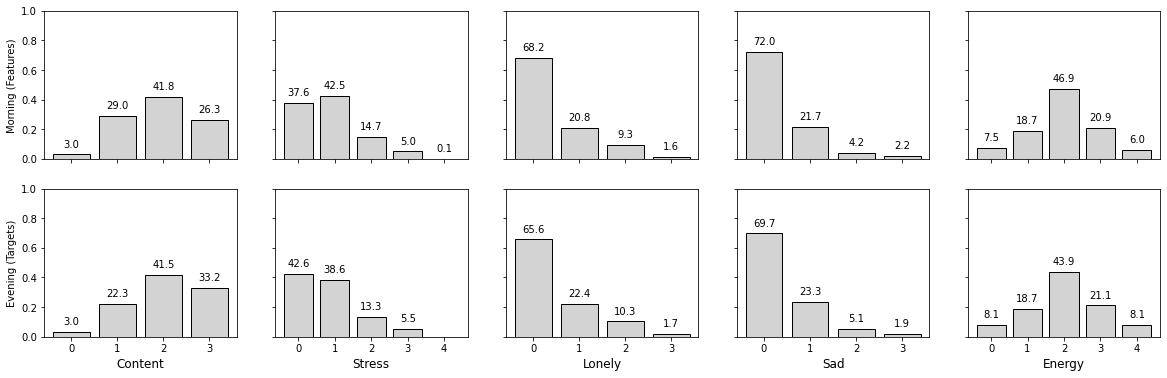

In [6]:
inspection = mood_prediction.Inspection()
_  = inspection.get_mood_distribution(data.mood_and_activity,plot=True)

## Difference in Scores (Evening - Morning)
The simplest way to understand the difference in mood scores is to simply subtract them from one another. The more identical the scores, the greater the instance of zero.

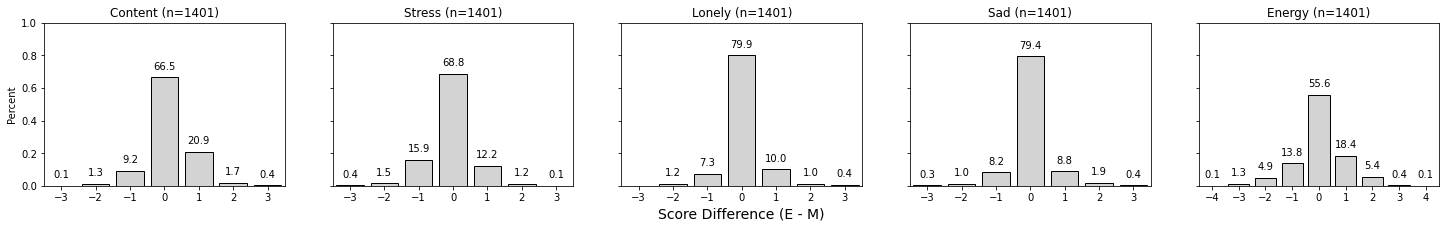

In [7]:
_ = inspection.get_mood_difference(data.mood_and_activity,plot=True)

<div class="alert alert-block alert-info">
    
As expected, many of the differences between the mood scores are zero. This finding is less apparent when considering `energy` which makes sense since the energy of the participants should change. However, I would expect this change to be skewed towards a positive difference (indicating participants were _more_ tired in the evening) but that is not the case. Although they could have low energy in the mornings when they initially wake up. 
    
</div>

<div class="alert alert-block alert-info">
    
The maximum percentages also highlight a sort of upper bound on the accuracy of the model. Just like with our previous analysis, the model might be biased to simply report the same mood score since that is the most influential factor it seems.
    
</div>

---

<a id='modeling'></a>

# Modeling

In [38]:
modeling = mood_prediction.Model()

## Adding Features
We add the `step_goal` feature which determine whether or not the participant was able to reach the 10K (default) step goal.

In [ ]:
data.mood_and_activity = modeling.binarize_steps(data.mood_and_activity)

## BIinarizing Datasets

In [ ]:
data_bi = binarize_mood(data.mood_and_activity)
data_bi_targets = binarize_mood(data.mood_and_activity,binarize_features=False)

## Comparing and Tuning Models
We test a slew of classification schemes to get the best model

### Defining Models and Hyperparameters to Tune
We use some common classifiers to predict the mood scores that should work for multi-class and binary outcomes.

### Grid Search
Using our favorite, we examine the scores for using these models using 5-fold cross-validation

### Multi-Class Classification

In [42]:
opt_res = modeling.optimize_models(data.mood_and_activity,modeling.model_params,additional_features=["step_goal"])

	Random Forest
		Elapsed Time:	 0:00:19.837754
		Best Score:	64.8
		Best Params:	{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Svc
		Elapsed Time:	 0:00:01.415795
		Best Score:	65.9
		Best Params:	{'kernel': 'linear'}
	Gradientboost
		Elapsed Time:	 0:01:02.388988
		Best Score:	66.2
		Best Params:	{'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
	Logistic Regression
		Elapsed Time:	 0:00:00.424766
		Best Score:	64.4
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:19.989268
		Best Score:	66.5
		Best Params:	{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100}
	Svc
		Elapsed Time:	 0:00:01.052114
		Best Score:	68.1
		Best Params:	{'kernel': 'rbf'}
	Gradientboost
		Elapsed Time:	 0:01:06.264387
		Best Score:	68.4
		Best Params:	{'max_depth': 1, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
	Logistic Regression
		Elaps

In [43]:
opt_res

,mood,model,best_score,best_params
0,content,random_forest,64.819163,"{'max_depth': 5, 'min_samples_leaf': 1, 'min_s..."
1,content,svc,65.940522,{'kernel': 'linear'}
2,content,gradientboost,66.164962,"{'max_depth': 1, 'min_samples_leaf': 1, 'min_s..."
3,content,logistic_regression,64.368886,"{'fit_intercept': True, 'solver': 'lbfgs'}"
4,stress,random_forest,66.463349,"{'max_depth': 5, 'min_samples_leaf': 1, 'min_s..."
5,stress,svc,68.115514,{'kernel': 'rbf'}
6,stress,gradientboost,68.415702,"{'max_depth': 1, 'min_samples_leaf': 2, 'min_s..."
7,stress,logistic_regression,66.240883,"{'fit_intercept': True, 'solver': 'lbfgs'}"
8,lonely,random_forest,79.325843,"{'max_depth': 4, 'min_samples_leaf': 1, 'min_s..."
9,lonely,svc,79.550562,{'kernel': 'linear'}


The table below highlights the results from running the tests on all moods.

| Mood    | Naive | Random Forest | SVC  | Gradient | Logistic Regression |
|---------|-------|---------------|------|----------|---------------------|
| Content | 67.3  | 67.1          | 67.4 | 67.5     | 67.3                |
| Stress  | 68.0  | 66.7          | 68.0 | 68.3     | 65.7                |
| Lonely  | 78.8  | 78.4          | 78.5 | 78.7     | 76.8                |
| Sad     | 79.5  | 78.9          | 78.3 | 79.2     | 78.2                |
| Energy  | 56.4  | 55.4          | 55.6 | 56.7     | 52.4                |

<div class="alert alert-block alert-info">
    
From this analysis, the models that we should consider are:
    
* Logistic Regression
* Support Vector
* Gradient Boost 
    
These models were the best-performing and operate on different principles which increases the diversity and strength of our results.
    
</div>

In [45]:
tuned_models = {"logistic_regression":LogisticRegression(random_state=42,fit_intercept=True,solver="lbfgs"),
                "svc":SVC(kernel="rbf"),
                "gradient":GradientBoostingClassifier(random_state=42,n_estimators=100,max_depth=1,min_samples_leaf=2,min_samples_split=2)}
modeling.set_tuned_models(tuned_models)

#### Binary Classsification
We conduct two binary classification models to understand the effect of binarizing the mood features.

In [ ]:
opt_res_binary = optimize_models(data_bi,model_params)

In [ ]:
opt_res_binary

The table below highlights the results from running the tests on all moods.

| Mood    | Naive | Random Forest | SVC  | Gradient | Logistic Regression |
|---------|-------|---------------|------|----------|---------------------|
| Content | 67.3  | 67.1          | 67.4 | 67.5     | 67.3                |
| Stress  | 68.0  | 66.7          | 68.0 | 68.3     | 65.7                |
| Lonely  | 78.8  | 78.4          | 78.5 | 78.7     | 76.8                |
| Sad     | 79.5  | 78.9          | 78.3 | 79.2     | 78.2                |
| Energy  | 56.4  | 55.4          | 55.6 | 56.7     | 52.4                |

In [ ]:
opt_res_binary_2 = optimize_models(data_bi_targets,model_params)

In [ ]:
opt_res_binary_2

<div class="alert alert-block alert-info">
    
From this analysis, we consider the same models as before despite random forest performing equally as well:
    
* Logistic Regression
* Support Vector
* Gradient Boost
    
</div>

In [48]:
tuned_models_bi = {"logistic_regression":LogisticRegression(random_state=42,fit_intercept=True,solver="lbfgs"),
                "svc":SVC(kernel="lienar"),
                "gradient":GradientBoostingClassifier(random_state=42,n_estimators=10,max_depth=1,min_samples_leaf=1,min_samples_split=2)}

## Cross-Validation
We will use three different techniques of cross-validation to compare and understand the sensitivity of our models to different sets of the data:
1. **Stratified K-Fold**: This method will ensure that the same ratio of the target classes are preserved which is important especially considering we have four classes in this instance compared to our binary evaluations in the past.
2. **Group K-Fold**: This method will help test the sensitivity to any particular participant groups.
3. **Leave One Group Out**: The most extreme method to understand the sensitivity of the model to a particular participant.

In [49]:
from sklearn.model_selection import StratifiedKFold, GroupKFold, LeaveOneGroupOut, cross_val_score

In [50]:
def cross_validate(df,models,cv_label="skf",moods=["content","stress","lonely","sad","energy"],n_splits=5,verbose=False):
    """
    Runs various cross-validation techniques on the provided models
    
    Parameters
    ----------
    df : DataFrame
    models : dict
        sklearn ML models to consider with keys corresponding to the string of the model name and the keys of the sklearn
        model with provided hyperparameters
    cv_label : {"skf","gkf","logo"}, default "skf"
        Specifies the type of cross-validation technique:
        "skf":stratified k-fold, "gkf":group k-fold, "logo":leave one group out
    moods : list-like of default ["content","stress","lonely","sad","energy"]
        moods to consider for the cross-validation - must be column(s) in df
    n_splits : int, default 5
        number of splits to perform for k-fold cross-validation techniques
    verbose : boolean, default False
        verbose mode for debugging primarily leave one group out cross-validation
    
    Returns
    -------
    <results> : DataFrame
        Cross-validation scores from each split and the average per each mood and model
    """
    if cv_label == "skf":
        cv = StratifiedKFold(n_splits=n_splits)
        groups = None # for consistency
        res = {key: [] for key in ["mood","model"] + [f"split_{i+1}" for i in range(n_splits)] + ["mean"]}
    elif cv_label == "gkf":
        cv = GroupKFold(n_splits=n_splits)
        res = {key: [] for key in ["mood","model"] + [f"split_{i+1}" for i in range(n_splits)] + ["mean"]}
    elif cv_label == "logo":
        cv = LeaveOneGroupOut()
        X,y,groups = get_x_and_y(df)
        if verbose:
            for train_index, test_index in cv.split(X, y, groups):
                print("TRAIN:", train_index, "TEST:", test_index)
                X_train, X_test = groups.iloc[train_index], groups.iloc[test_index]
                print(X_train, X_test)
        res = {key: [] for key in ["mood","model"] + [f"{pt} ({n})" for pt, n in zip(groups.unique(),groups.value_counts().sort_index())] + ["mean"]}
    else:
        raise NameError(f"{cv_label} is an invalid option - choose one of ['skf','gkf','logo']")
        
    for mood in moods:
        for model in models.keys():
            X, y, groups = get_x_and_y(df,mood=mood)
            clf = models[model]
            scores = cross_val_score(clf, X, y, cv=cv, groups=groups)
            values = [mood,model]+list(scores)+[np.mean(scores)]
            for key, value in zip(res.keys(),values):
                res[key].append(value)
                
    return pd.DataFrame(data=res)

### Results: Stratified K-Fold

In [51]:
#res_skf = cross_validate(data,tuned_models,cv_label="skf")
res_skf

NameError: name 'res_skf' is not defined

<div class="alert alert-block alert-success">
    
Models tend to be rather consistent amongst the various splits - varying by ~0.5 at the most.
    
</div>

### Group K-Fold

In [52]:
#res_gkf = cross_validate(data,tuned_models,cv_label="gkf")
res_gkf

NameError: name 'res_gkf' is not defined

<div class="alert alert-block alert-success">
    
Similar results to the stratified split both in terms of variation and average scores.
    
</div>

In [53]:
#res_logo = cross_validate(data,tuned_models,cv_label="logo")
res_logo

NameError: name 'res_logo' is not defined

<div class="alert alert-block alert-warning">
    
The scores vary widely most likely influenced by the number of datapoints that each participant provides. If those values are low, then the results could either be very _low_ indicating dramatically different responses are very _high_ indicating the same response. Further scrutiny is warranted and condcuted in the [Inspection](#inspection) section.
    
</div>

# Prediction
Since our models seemed to pass the test with the cross-validation, now we can use them to predict the outcomes. 

In [54]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split

In [93]:
def get_predictions(df,mood,model,probability=False, include_evening=False):
    """
    Gets the predictions for the given mood
    
    """
    X, y, _ = get_x_and_y(df,mood,include_evening=include_evening)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    clf = model.fit(X_train,y_train)
    
    if probability:
        pred = clf.predict_proba(X_test)[:, 1]
    else:
        pred = clf.predict(X_test)
    return y_test, pred

In [63]:
y_true, y_pred = get_predictions(data_bi,"content",tuned_models["logistic_regression"],include_evening=False)

# Evaluation
[Here](https://towardsdatascience.com/comprehensive-guide-on-multiclass-classification-metrics-af94cfb83fbd) is a nice article regarding various metrics to consider.

## Confusion Matrices
We can look at how well our models perform by considering the confusion matrices.

In [64]:
from sklearn.metrics import confusion_matrix

In [65]:
def get_cm(y_true,y_pred,plot=False):
    """
    Returns confusion matrix
    
    Parameters
    ----------
    y_true : list
        the actual values
    y_pred : list
        the predicted values
    plot : boolean
        whether or not to dispaly the confusion matrices
        
    Returns
    -------
    cm : list of lists
        the confusion matrix
    """
    cm = confusion_matrix(y_true, y_pred)
    
    if plot:
        _, ax = plt.subplots(figsize=(5,5))
        sns.heatmap(pd.DataFrame(cm),vmin=0,
                    linecolor="black",linewidth=1,cmap="viridis",     
                    square=True,annot=True,fmt='d',ax=ax)
        ax.set_xticklabels(np.arange(len(np.unique(y_true))),fontsize=12,rotation=0)
        ax.set_xlabel("Predicted Value",fontsize=14)
        ax.set_yticklabels(np.arange(len(np.unique(y_true))),fontsize=12,rotation=0)
        ax.set_ylabel("True Value",fontsize=14)
        plt.show()
        plt.close()
    
    return cm

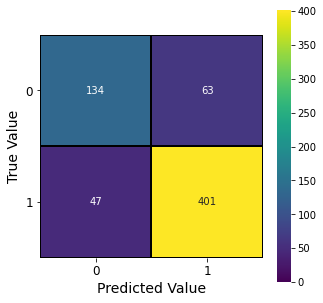

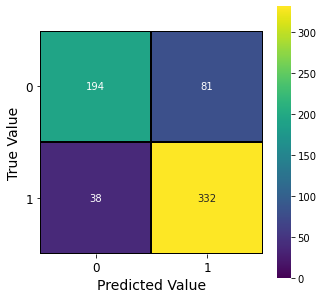

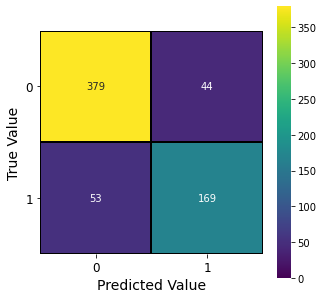

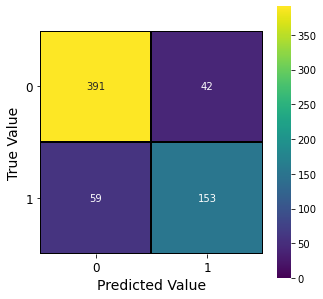

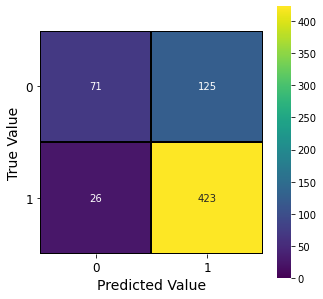

In [72]:
for mood in ["content","stress","lonely","sad","energy"]:
    y_true, y_pred = get_predictions(data_bi,mood,tuned_models["logistic_regression"],include_evening=True)
    _ = get_cm(y_true, y_pred, plot=True)

### Defining the Confusion Matrix
* **Positive Classes**: 2 and 3
* **Negative Classes**: 0 and 1

## All the metrics
Who knew there was a fancy function for all this? In addition, we borrow some advice from the TDS crew.

In [67]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, cohen_kappa_score,log_loss

In [95]:
def get_scoring_metrics(df_in,model,moods=["content","stress","lonely","sad","energy"],include_evening=False):
    """
    Gets the various scoring metrics
    """
    df = df_in.copy()
    res = {"mood":[],"accuracy":[],"precision":[],"recall":[],"roc_auc":[],"f1":[],"kappa":[],"log-loss":[]}
    for mood in moods:
        y_true, y_pred = get_predictions(df,mood,model,include_evening=include_evening)
        _, y_pred_prob = get_predictions(df,mood,model,probability=True,include_evening=include_evening)
        res["mood"].append(mood)
        res["accuracy"].append(accuracy_score(y_true,y_pred))
        res["precision"].append(precision_score(y_true,y_pred, average="weighted"))
        res["recall"].append(recall_score(y_true,y_pred, average="weighted"))
        res["roc_auc"].append(roc_auc_score(y_true, y_pred_prob, multi_class="ovr", average="weighted"))
        res["f1"].append(f1_score(y_true,y_pred, average="weighted"))
        res["kappa"].append(cohen_kappa_score(y_true,y_pred))
        res["log-loss"].append(log_loss(y_true,y_pred_prob))
        
    return pd.DataFrame(res)

In [98]:
get_scoring_metrics(data_bi,tuned_models["logistic_regression"],include_evening=False)

,mood,accuracy,precision,recall,roc_auc,f1,kappa,log-loss
0,content,0.829457,0.840188,0.829457,0.837382,0.832705,0.615539,0.422636
1,stress,0.810853,0.811964,0.810853,0.856585,0.808453,0.606333,0.456103
2,lonely,0.851163,0.849389,0.851163,0.859572,0.849371,0.663097,0.415551
3,sad,0.841860,0.840057,0.841860,0.861002,0.840638,0.636399,0.411995
4,energy,0.753488,0.742699,0.753488,0.746744,0.723170,0.318368,0.518522


In [99]:
get_scoring_metrics(data_bi,tuned_models["logistic_regression"],include_evening=True)

,mood,accuracy,precision,recall,roc_auc,f1,kappa,log-loss
0,content,0.829457,0.826384,0.829457,0.876870,0.827344,0.588686,0.396304
1,stress,0.815504,0.817659,0.815504,0.878713,0.812746,0.615099,0.432587
2,lonely,0.849612,0.848442,0.849612,0.891072,0.848848,0.663634,0.380540
3,sad,0.843411,0.841190,0.843411,0.894195,0.841648,0.637751,0.374088
4,energy,0.765891,0.759761,0.765891,0.787174,0.737964,0.354833,0.501132


In [ ]:
def get_report(df,model,mood="content"):
    """
    Gets the classification report and prints it
    
    """
    y_true, y_pred = get_predictions(df,mood,model)
    print(mood)
    print(classification_report(y_true, y_pred))

In [ ]:
get_report(data,tuned_models["logistic_regression"],"lonely")

---

[Back to Top](#top)